In [1]:
import sys
%pylab inline
sys.path.insert(0,"../src")

Populating the interactive namespace from numpy and matplotlib


In [2]:
import utils
import os
import data
import tree_split

In [3]:
rawtraindf, traindf, testdf, submissiondf = data.get_data(return_normalized=True, onehot=True,train_expand=True)

['Age', 'base_Weeks', 'SmokingStatus', 'SmokingStatus_2', 'weeks_since_base', 'base_ref_FVC', 'base_Percent', 'Sex', 'base_FVC', 'SmokingStatus_1']
rmse: 225.53770072803806 mean err: -3.8958929612720485e-14


In [4]:
traindf=traindf[traindf['weeks_since_base']>0]

In [5]:
for u in [rawtraindf, traindf, testdf, submissiondf]:
    print(u.shape)

(1542, 16)
(5919, 22)
(5, 19)
(730, 14)


In [5]:
traindf.head()

Patient  Weeks     FVC    Percent  base_Weeks  base_FVC  \
0  ID00400637202305055099402     29  3962.0  88.382261          29    3962.0   
1  ID00400637202305055099402     30  3936.0  87.802266          30    3936.0   
2  ID00400637202305055099402     32  3895.0  86.887659          32    3895.0   
3  ID00400637202305055099402     33  3924.0  87.534577          33    3924.0   
4  ID00400637202305055099402     36  3856.0  86.017668          36    3856.0   

   base_Percent  Age  Sex  SmokingStatus  base_ref_FVC  weeks_since_base  \
0     88.382261   55    0              1        4482.8                 0   
1     87.802266   55    0              1        4482.8                 0   
2     86.887659   55    0              1        4482.8                 0   
3     87.534577   55    0              1        4482.8                 0   
4     86.017668   55    0              1        4482.8                 0   

    log_FVC  log_base_FVC  norm_FVC  norm_Age  norm_base_Percent  \
0  8.284504      8.284504  1.525623 -1.729014           0.409687   
1  8.277920      8.277920  1.494401 -1.729014           0.379649   
2  8.267449      8.267449  1.445165 -1.729014           0.332282   
3  8.274867      8.274867  1.479990 -1.729014           0.365786   
4  8.257386      8.257386  1.398332 -1.729014           0.287225   

   norm_base_FVC  norm_base_ref_FVC  norm_weeks_since_base  
0       1.404548           1.328788              -0.987717  
1       1.373449           1.328788              -0.987717  
2       1.324408           1.328788              -0.987717  
3       1.359095           1.328788              -0.987717  
4       1.277760           1.328788              -0.987717

In [6]:
FEATS= [x for x in traindf.columns if x.startswith('norm_') and x !="norm_FVC"] + ['Sex', 'SmokingStatus',]
TARGET='norm_FVC'

In [7]:
traindf[FEATS].describe()

norm_Age  norm_base_Percent  norm_base_FVC  norm_base_ref_FVC  \
count  13330.000000       13330.000000   13330.000000       13330.000000   
mean      -0.010306          -0.134377      -0.104741           0.008537   
std        1.001458           1.006135       0.977086           0.998894   
min       -2.578826          -2.672053      -2.345262          -2.551444   
25%       -0.595931          -0.894275      -0.798690          -0.493532   
50%        0.112246          -0.234279      -0.136642           0.219035   
75%        0.678788           0.423884       0.467992           0.696412   
max        2.944954           3.763761       4.319471           1.921337   

       norm_weeks_since_base           Sex  SmokingStatus  
count           13330.000000  13330.000000   13330.000000  
mean               -0.991503      0.209452       0.780345  
std                 1.389280      0.406933       0.529202  
min                -4.564570      0.000000       0.000000  
25%                -1.669022      0.000000       0.000000  
50%                -0.987717      0.000000       1.000000  
75%                -0.306411      0.000000       1.000000  
max                 2.589137      1.000000       2.000000

In [8]:
testdf[FEATS].describe()

norm_Age  norm_base_Percent  norm_base_FVC  norm_base_ref_FVC  \
count  5.000000           5.000000       5.000000           5.000000   
mean   0.650461          -0.231708      -0.007342           0.245084   
std    0.307058           0.257445       0.617763           1.006235   
min    0.112246          -0.532651      -1.025951          -1.315889   
25%    0.678788          -0.447813      -0.058297          -0.210981   
50%    0.820423          -0.196760       0.164180           0.776602   
75%    0.820423          -0.062811       0.277811           0.889084   
max    0.820423           0.081496       0.605545           1.086601   

       norm_weeks_since_base  Sex  SmokingStatus  
count               5.000000  5.0       5.000000  
mean               -0.987717  0.0       0.800000  
std                 0.000000  0.0       0.447214  
min                -0.987717  0.0       0.000000  
25%                -0.987717  0.0       1.000000  
50%                -0.987717  0.0       1.000000  
75%                -0.987717  0.0       1.000000  
max                -0.987717  0.0       1.000000

In [9]:
str(FEATS)

"['norm_Age', 'norm_base_Percent', 'norm_base_FVC', 'norm_base_ref_FVC', 'norm_weeks_since_base', 'Sex', 'SmokingStatus']"

In [10]:
folds=data.make_kfold(traindf)

In [11]:
def get_topology(self):
    d= self.to_dict()
    print (d)
    l=[]
    def f(n):
        if (n['id']==0):
            l.append('root')
        else:
            l.append(n['attrib']['varname'])
        if 'children' in n:
            for u in n['children']:
                f(u['node'])
    f(d['graph']['node'])
    return l

In [12]:
class Leave:
    def __init__(self, tuples=None):
        if tuples is None:
            tuples=[]
        self.tuples=tuples
    
    def apply(self,df):
        if self.tuples:
            for v,op,p in self.tuples:
                if op=='left':
                    df=df[df[v]<=p]
                else:
                    df=df[df[v]>p]
        return df

    def split(self,df, feat,TARGET):
        df=self.apply(df)
        X = tree_split.propose(df, [feat], TARGET)
        assert len(X)==1
        X=X[0]
        l1 = Leave( self.tuples +[(X[0], 'left', X[1][0])])
        l2 = Leave( self.tuples +[(X[0], 'right', X[1][0])])
        return l1,l2

    def __repr__(self):
        return "Leave: "+ str([str(u) for u in self.tuples])

class Tree:
    def __init__(self,leaves=None):
        if leaves is None:
            leaves=[Leave()]
        self.leaves=leaves
    
    def split(self,df,feat,TARGET):
        ret=[]
        for leave in self.leaves:
            remain_ = [u for u in self.leaves if u!=leave]
            l,r=leave.split(df,feat, TARGET)
            ret.append(Tree(remain_ + [l,r] ))
        return ret   
    
    def apply(self,df,TARGET):
        df['level']=np.nan
        for i,leave in enumerate(self.leaves):
            adf =leave.apply(df)
            df.loc[adf.index, 'level']=i
        assert df['level'].isnull().sum()==0
        df['level']=df['level'].astype(np.int)
        return df
    
    def size(self):
        return len(self.leaves)
    
    def __repr__(self):
        s="Tree: {\n"
        for l in self.leaves:
            s += "        "+str(l)+"\n"
        s+="       }\n"
        return s
    

In [13]:
root=Tree()
a = root.split(traindf, FEATS[0], TARGET)
print(a)

[Tree: {
        Leave: ["('norm_Age', 'left', 0.8204232634261159)"]
        Leave: ["('norm_Age', 'right', 0.8204232634261159)"]
       }
]


In [14]:
traindf.shape

(13330, 20)

In [15]:
a[0].apply(traindf, TARGET)['level'].value_counts()

0    11239
1     2091
Name: level, dtype: int64

In [16]:
b=a[0].split(traindf, FEATS[1], TARGET)
b

[Tree: {
         Leave: ["('norm_Age', 'right', 0.8204232634261159)"]
         Leave: ["('norm_Age', 'left', 0.8204232634261159)", "('norm_base_Percent', 'left', -0.33273854405030867)"]
         Leave: ["('norm_Age', 'left', 0.8204232634261159)", "('norm_base_Percent', 'right', -0.33273854405030867)"]
        },
 Tree: {
         Leave: ["('norm_Age', 'left', 0.8204232634261159)"]
         Leave: ["('norm_Age', 'right', 0.8204232634261159)", "('norm_base_Percent', 'left', -1.6128795473216182)"]
         Leave: ["('norm_Age', 'right', 0.8204232634261159)", "('norm_base_Percent', 'right', -1.6128795473216182)"]
        }]

In [17]:
b[0].apply(traindf, TARGET)['level'].value_counts()

2    5930
1    5309
0    2091
Name: level, dtype: int64

In [18]:
c=b[0].split(traindf, FEATS[3], TARGET)
c

[Tree: {
         Leave: ["('norm_Age', 'left', 0.8204232634261159)", "('norm_base_Percent', 'left', -0.33273854405030867)"]
         Leave: ["('norm_Age', 'left', 0.8204232634261159)", "('norm_base_Percent', 'right', -0.33273854405030867)"]
         Leave: ["('norm_Age', 'right', 0.8204232634261159)", "('norm_base_ref_FVC', 'left', -0.14585933364762918)"]
         Leave: ["('norm_Age', 'right', 0.8204232634261159)", "('norm_base_ref_FVC', 'right', -0.14585933364762918)"]
        },
 Tree: {
         Leave: ["('norm_Age', 'right', 0.8204232634261159)"]
         Leave: ["('norm_Age', 'left', 0.8204232634261159)", "('norm_base_Percent', 'right', -0.33273854405030867)"]
         Leave: ["('norm_Age', 'left', 0.8204232634261159)", "('norm_base_Percent', 'left', -0.33273854405030867)", "('norm_base_ref_FVC', 'left', -0.5715694463093227)"]
         Leave: ["('norm_Age', 'left', 0.8204232634261159)", "('norm_base_Percent', 'left', -0.33273854405030867)", "('norm_base_ref_FVC', 'right', -0.571

In [19]:
c[0].apply(traindf, TARGET)['level'].value_counts()

1    5930
0    5309
2    1249
3     842
Name: level, dtype: int64

In [20]:
from statsmodels.robust.scale import huber
def laplace_loss2(y_pred, sigma_pred, y_true):
    SCALE=data.scalers['FVC'].scale_
    C1=70./SCALE
    C2=1000./SCALE    
    sigma = sigma_pred.copy()
    sigma[sigma<C1]=C1
    delta = np.abs(y_true - y_pred)
    delta[delta>C2]=C2
    sq2 = np.sqrt(2)
    metric = (delta / sigma)*sq2 + np.log(sigma* sq2) +np.log(SCALE)
    return metric

def helper_loss(model_pred, y_true):
    X=model_pred['y']
    if 0:
        y_pred=X.mean(0)
        sigma_pred=X.std(0)
    else:
        y_pred, sigma_pred =np.apply_along_axis(huber,axis=0, arr=X)

    return laplace_loss2(y_pred, sigma_pred, y_true)

In [21]:
import pymc3 as pm
import arviz as az

RANDOM_SEED=123
def train(traindf,testdf, n_level):
    print("train", traindf['level'].value_counts())
    print("test", testdf['level'].value_counts())
    LEVELS=list(range(n_level))
    coords = {
        "index": traindf.index,
        "feat": FEATS,
        "level":LEVELS
    }
    
    with pm.Model(coords=coords) as model:
        level_idx = pm.Data("level_idx", traindf['level'].values, dims="index")
        norm_weeks_since_base=pm.Data("weeks_since_base", traindf['norm_weeks_since_base'].values, dims="index")
        base_y=pm.Data('base_FVC', traindf['norm_base_FVC'].values,dims="index")

        alpha = pm.Normal("alpha", 0.0, sigma=10.0, dims="level")

        #prior for t
        beta=pm.Normal('beta', mu=0.0, sigma=10.0, dims='level')

        theta = alpha[level_idx] +base_y + beta[level_idx]*norm_weeks_since_base
        sigma = pm.Exponential("sigma", 1.0)

        y = pm.Normal("y", theta, sigma=sigma, observed=traindf[TARGET].values, dims="index")  
    
    display(pm.model_to_graphviz(model))
    with  model:
        trace = pm.sample(10000,init='adapt_diag', return_inferencedata=False,random_seed=RANDOM_SEED)
        idata=az.from_pymc3(trace) 
        display(az.summary(idata, round_to=2))
        az.plot_trace(idata);plt.show()
        az.plot_forest(idata, r_hat=True, combined=True, textsize=9);plt.show()
        post_pred = pm.sample_posterior_predictive(idata, samples=1000,random_seed=RANDOM_SEED)
        train_loss=helper_loss(post_pred,traindf[TARGET].values).mean()
    with  model:
        pm.set_data({"level_idx": testdf['level'].values,
                     "weeks_since_base": testdf['norm_weeks_since_base'].values,
                     "base_FVC": testdf['norm_base_FVC'].values,
                    })
        post_pred = pm.sample_posterior_predictive(idata, samples=1000,random_seed=RANDOM_SEED)        
        test_loss=helper_loss(post_pred,testdf[TARGET].values).mean()
    return train_loss, test_loss
    

In [22]:
import warnings
from pandas.core.common import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)

# Run

In [23]:
#os.environ['SPLIT_FEAT']=FEATS[0]

In [24]:
import os
SPLIT_FEAT=os.environ['SPLIT_FEAT']
print("Use feat", SPLIT_FEAT)

Use feat norm_Age


splits: Tree: {
        Leave: ["('norm_Age', 'left', 0.8204232634261159)"]
        Leave: ["('norm_Age', 'right', 0.8204232634261159)"]
       }

train 0    9109
1    1558
Name: level, dtype: int64
test 0    2130
1     533
Name: level, dtype: int64


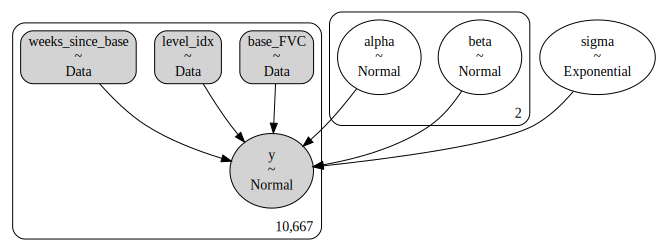

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 45 seconds.


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean    ess_sd  \
alpha[0]  0.03  0.00    0.03     0.04        0.0      0.0  31493.49  31406.79   
alpha[1]  0.07  0.01    0.06     0.08        0.0      0.0  31381.01  31313.62   
beta[0]  -0.08  0.00   -0.09    -0.08        0.0      0.0  32526.16  32510.79   
beta[1]  -0.05  0.00   -0.05    -0.04        0.0      0.0  31970.43  31941.37   
sigma     0.23  0.00    0.22     0.23        0.0      0.0  41648.71  41642.33   

          ess_bulk  ess_tail  r_hat  
alpha[0]  31505.85  31555.46    1.0  
alpha[1]  31364.08  31241.43    1.0  
beta[0]   32512.11  30423.61    1.0  
beta[1]   31978.82  32430.63    1.0  
sigma     41646.20  31553.31    1.0

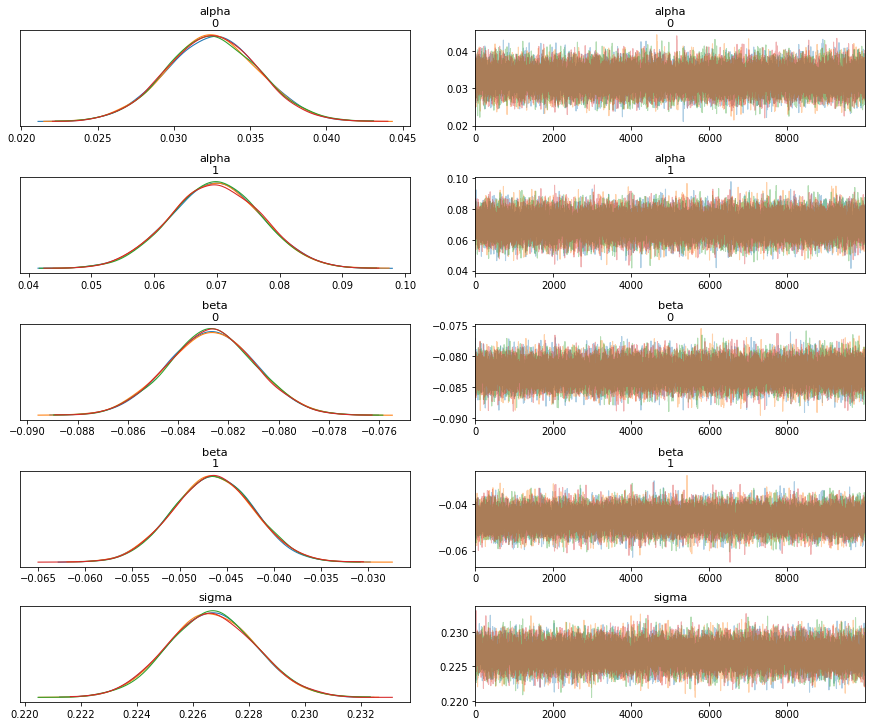

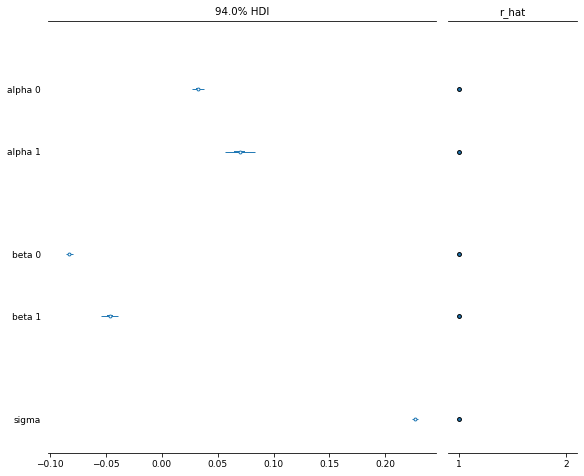

/home/bo/miniconda3/envs/osic/lib/python3.7/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


/home/bo/miniconda3/envs/osic/lib/python3.7/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


loss:  [6.5276291597031975, 6.603102720862906]
splits: Tree: {
        Leave: ["('norm_Age', 'left', 0.8204232634261159)"]
        Leave: ["('norm_Age', 'right', 0.8204232634261159)"]
       }

train 0    9036
1    1609
Name: level, dtype: int64
test 0    2203
1     482
Name: level, dtype: int64


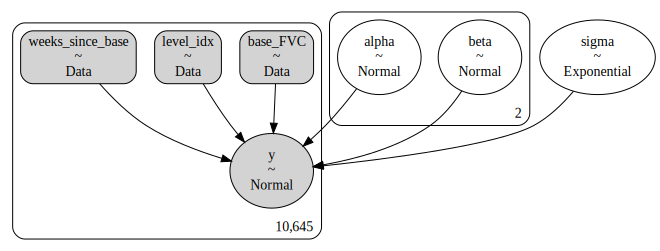

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 49 seconds.


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean    ess_sd  \
alpha[0]  0.04  0.00    0.03     0.04        0.0      0.0  36754.35  36754.35   
alpha[1]  0.06  0.01    0.05     0.07        0.0      0.0  30424.73  30359.71   
beta[0]  -0.08  0.00   -0.08    -0.08        0.0      0.0  34885.18  34884.03   
beta[1]  -0.05  0.00   -0.06    -0.05        0.0      0.0  31254.86  31220.44   
sigma     0.23  0.00    0.22     0.23        0.0      0.0  35944.87  35932.00   

          ess_bulk  ess_tail  r_hat  
alpha[0]  36760.37  32745.80    1.0  
alpha[1]  30422.11  30543.82    1.0  
beta[0]   34892.05  31955.77    1.0  
beta[1]   31250.27  29698.02    1.0  
sigma     35977.98  29424.59    1.0

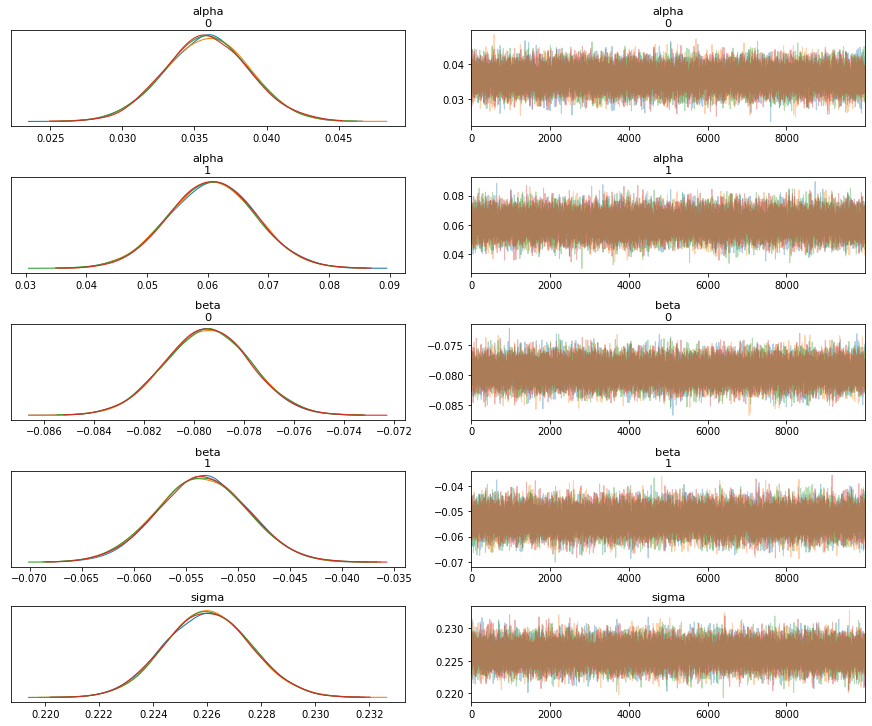

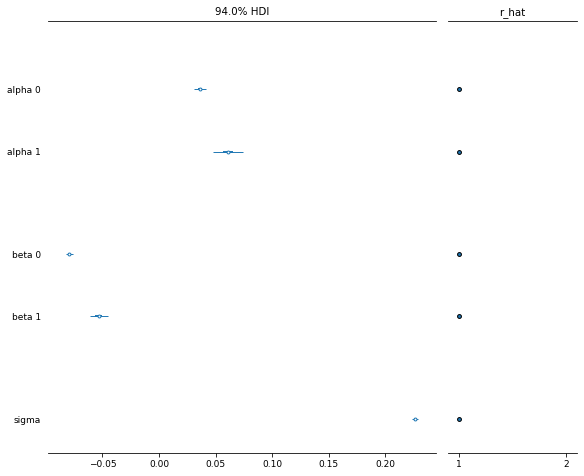

/home/bo/miniconda3/envs/osic/lib/python3.7/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


loss:  [6.5411062761101695, 6.546094883887214]
splits: Tree: {
        Leave: ["('norm_Age', 'left', 0.8204232634261159)"]
        Leave: ["('norm_Age', 'right', 0.8204232634261159)"]
       }

train 0    8744
1    1929
Name: level, dtype: int64
test 0    2495
1     162
Name: level, dtype: int64


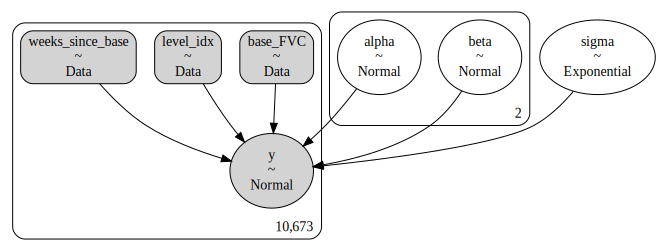

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 49 seconds.


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean    ess_sd  \
alpha[0]  0.03  0.00    0.03     0.04        0.0      0.0  29823.24  29732.51   
alpha[1]  0.08  0.01    0.07     0.09        0.0      0.0  31213.19  31075.61   
beta[0]  -0.08  0.00   -0.09    -0.08        0.0      0.0  30370.09  30370.09   
beta[1]  -0.04  0.00   -0.04    -0.03        0.0      0.0  30460.74  30460.74   
sigma     0.22  0.00    0.22     0.22        0.0      0.0  46665.01  46659.32   

          ess_bulk  ess_tail  r_hat  
alpha[0]  29827.52  29367.77    1.0  
alpha[1]  31299.53  32527.04    1.0  
beta[0]   30365.98  31004.38    1.0  
beta[1]   30475.47  30208.63    1.0  
sigma     46679.22  31149.88    1.0

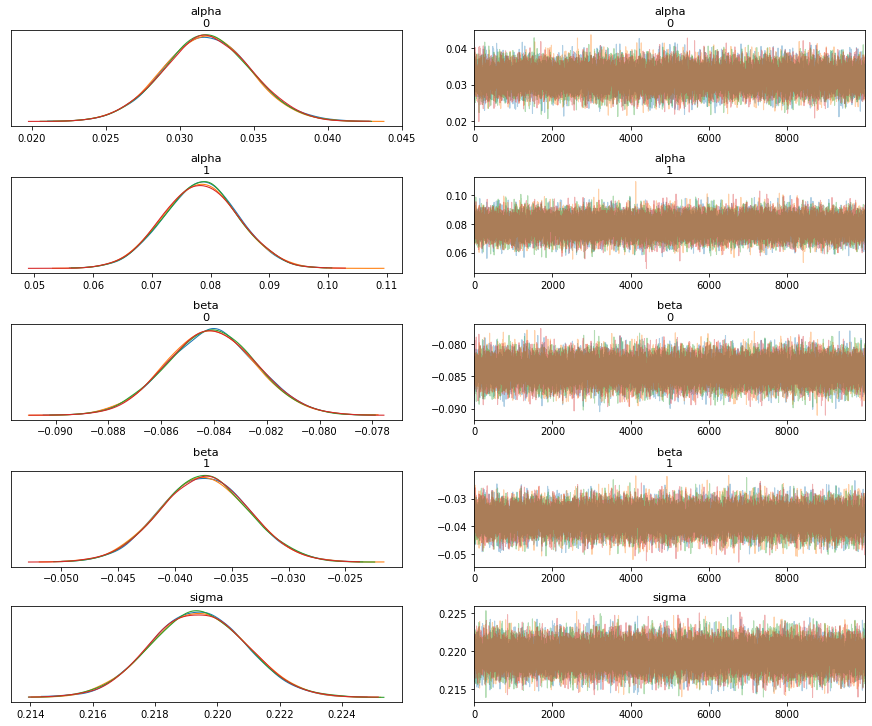

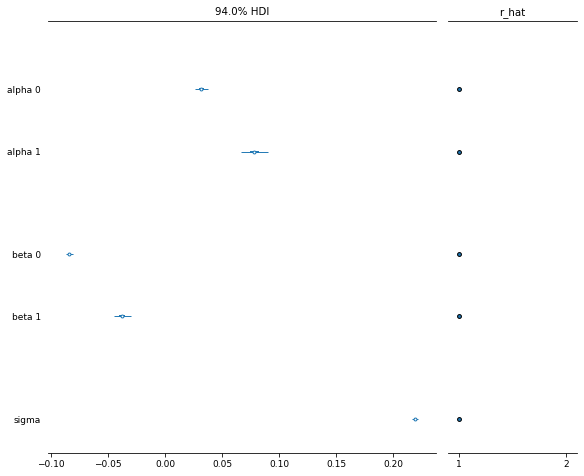

/home/bo/miniconda3/envs/osic/lib/python3.7/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


loss:  [6.528228960084961, 6.5943372295036955]
splits: Tree: {
        Leave: ["('norm_Age', 'left', 0.8204232634261159)"]
        Leave: ["('norm_Age', 'right', 0.8204232634261159)"]
       }

train 0    9025
1    1646
Name: level, dtype: int64
test 0    2214
1     445
Name: level, dtype: int64


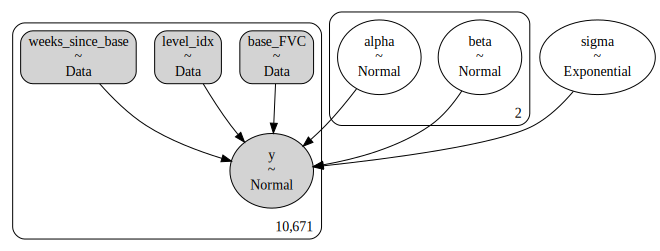

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 49 seconds.


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean    ess_sd  \
alpha[0]  0.03  0.00    0.02     0.03        0.0      0.0  30501.17  30501.17   
alpha[1]  0.07  0.01    0.06     0.08        0.0      0.0  31187.18  31040.75   
beta[0]  -0.09  0.00   -0.09    -0.08        0.0      0.0  31487.42  31487.42   
beta[1]  -0.05  0.00   -0.05    -0.04        0.0      0.0  31813.56  31813.56   
sigma     0.23  0.00    0.23     0.24        0.0      0.0  38705.84  38705.84   

          ess_bulk  ess_tail  r_hat  
alpha[0]  30482.12  32208.62    1.0  
alpha[1]  31188.79  31558.05    1.0  
beta[0]   31484.18  31408.36    1.0  
beta[1]   31818.42  32169.47    1.0  
sigma     38719.28  31461.83    1.0

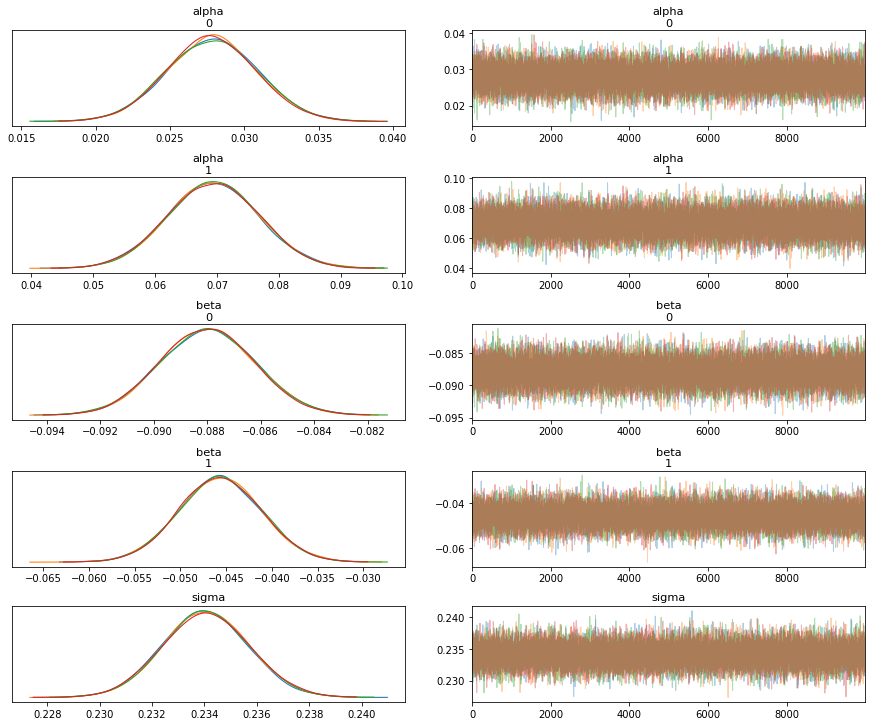

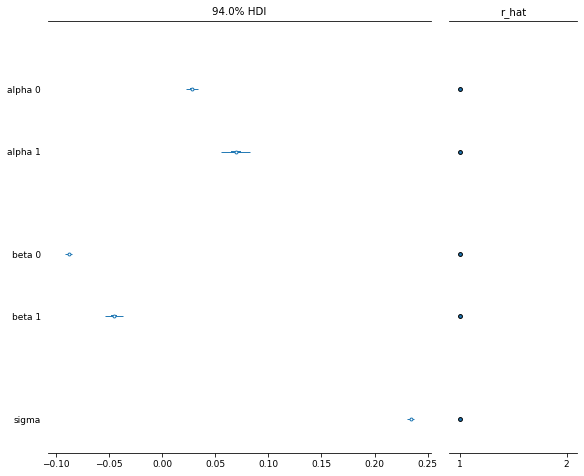

/home/bo/miniconda3/envs/osic/lib/python3.7/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


loss:  [6.561765003178646, 6.480639509207626]
splits: Tree: {
        Leave: ["('norm_Age', 'left', 0.8204232634261159)"]
        Leave: ["('norm_Age', 'right', 0.8204232634261159)"]
       }

train 0    9042
1    1622
Name: level, dtype: int64
test 0    2197
1     469
Name: level, dtype: int64


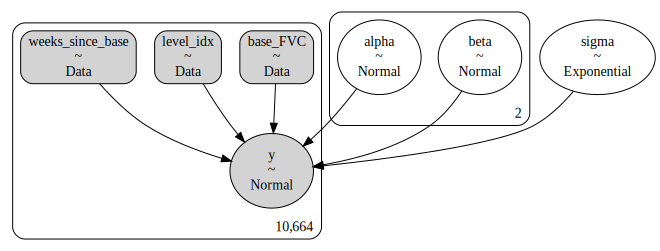

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, beta, alpha]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 50 seconds.


mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean    ess_sd  \
alpha[0]  0.04  0.00    0.03     0.04        0.0      0.0  31717.57  31717.57   
alpha[1]  0.07  0.01    0.06     0.09        0.0      0.0  30784.77  30728.98   
beta[0]  -0.08  0.00   -0.08    -0.08        0.0      0.0  30800.37  30780.16   
beta[1]  -0.04  0.00   -0.05    -0.04        0.0      0.0  31955.47  31955.47   
sigma     0.23  0.00    0.23     0.23        0.0      0.0  41588.95  41588.95   

          ess_bulk  ess_tail  r_hat  
alpha[0]  31719.82  31427.33    1.0  
alpha[1]  30785.52  31910.39    1.0  
beta[0]   30776.98  30472.06    1.0  
beta[1]   31945.92  31958.74    1.0  
sigma     41577.01  31615.42    1.0

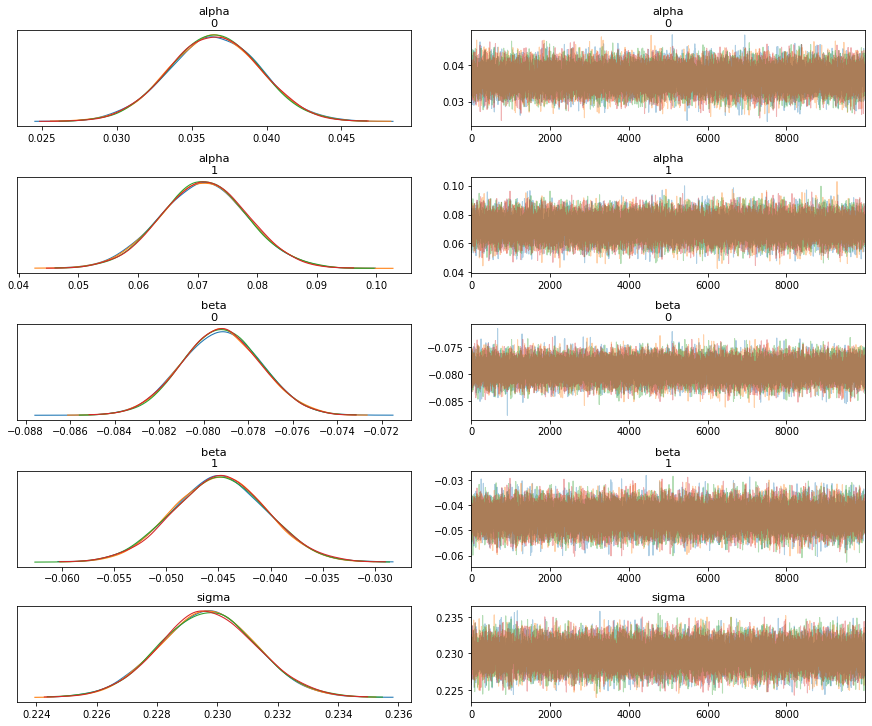

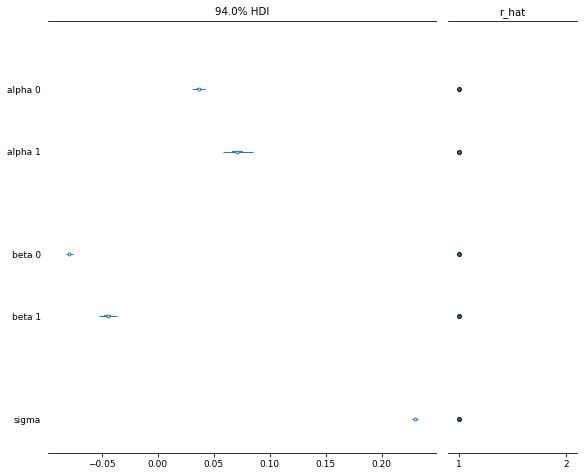

/home/bo/miniconda3/envs/osic/lib/python3.7/site-packages/pymc3/sampling.py:1708: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


loss:  [6.553190345602223, 6.499485820694511]


In [25]:
losses=[]
for adf,bdf in folds:
    adf['__tree_target__']=adf['norm_FVC']-adf['norm_base_FVC']
    root=Tree()
    a = root.split(adf, SPLIT_FEAT, TARGET)
    assert len(a)==1
    tree=a[0]
    print("splits:", tree)

    adf=tree.apply(adf,TARGET)
    bdf=tree.apply(bdf,TARGET)
    train_loss,test_loss=train(adf,bdf, tree.size())
    losses.append([train_loss,test_loss])
    print("loss: ", losses[-1])    

In [26]:
losses

[[6.5276291597031975, 6.603102720862906],
 [6.5411062761101695, 6.546094883887214],
 [6.528228960084961, 6.5943372295036955],
 [6.561765003178646, 6.480639509207626],
 [6.553190345602223, 6.499485820694511]]

In [27]:
print(list(zip(["train","test"], np.mean(losses,0))))

[('train', 6.542383948935838), ('test', 6.54473203283119)]
